In [2]:
import pickle
import gzip
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import EarlyStopping, TensorBoard
from keras.activations import *
from keras.utils import to_categorical
from keras import optimizers
from keras.optimizers import *
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from collections import Counter
import itertools

Using TensorFlow backend.


## Load MNIST on Python 3.x


In [3]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

## Load USPS on Python 3.x

In [4]:
USPSMat  = []
USPSTar  = []
curPath  = 'C:/Users/Monisha Balaji/Downloads/USPSdata/USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

## DEEP NEURAL NETWORK

In [6]:
# Process the MNIST data
train_f, train_label = training_data
train_label_en = to_categorical(train_label)
val_f, val_label = validation_data
val_label_en = to_categorical(val_label)
test_f, test_label = test_data
test_label_en = to_categorical(test_label)
train_f.shape

(50000, 784)

In [7]:
#Process the USPS data
usps_tf  = np.array(USPSMat) 
usps_tlabel  = np.array(USPSTar)
usps_tlabel_en = to_categorical(usps_tlabel)
usps_tlabel.shape

(19999,)

In [6]:
def generate_model():
    input_shape=train_f[1].shape
    layers=[100, 50, 25]
    dropout=0.2
    model = Sequential()
    model.add(Dense(layers[0], activation='relu',input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(layers[1], activation='relu',input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(layers[2], activation='relu',input_shape=input_shape))
    model.add(Dropout(dropout))
    model.pop()
    model.add(Dense(10, activation='softmax'))
    model.summary()
    sgd = optimizers.SGD(lr=0.01)
    model.compile(optimizer=sgd, loss=K.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

In [7]:
def train_model():
    dnn=generate_model()
    num_epochs= 20
    # Creating callbacks
    ten_cb = TensorBoard(log_dir='./logs/dnn', histogram_freq=0, batch_size=32, write_graph=True)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=10, patience=100, verbose=1, mode='auto', baseline=None)
    
    history = dnn.fit(train_f
                        , train_label_en
                        , validation_data=[val_f, val_label_en]
                        , epochs=num_epochs
                        , callbacks = [ten_cb,early_stop])
    return dnn

In [8]:
def evaluate_model(dnn, test_f, test_label_en,test_label):
    loss, acc = dnn.evaluate(test_f, test_label_en)
    print("Test Loss:", loss)
    print("Test Accuracy:", acc * 100.)
    pred_test=dnn.predict_classes(test_f)
    cm = confusion_matrix(test_label, pred_test)
    print(cm)
    return cm

In [9]:
def evaluate(dnn, test_f, test_label_en,test_label):
    loss, acc = dnn.evaluate(test_f, test_label_en)
    print("Test Loss:", loss)
    print("Test Accuracy:", acc * 100.)
    pred_test=dnn.predict_classes(test_f)

In [10]:
# Train and Run the Deep Neural Network model
dnn = train_model()
conf_m = evaluate_model(dnn,test_f, test_label_en,test_label)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                260       
Total params: 85,085
Trainable params: 85,085
Non-trainable params: 0
_________________________________________________________________
Train 

In [11]:
evaluate(dnn,usps_tf, usps_tlabel_en,usps_tlabel_en)

19999/19999 [==============================] - 1s 42us/step
Test Loss: 2.5917686816543166
Test Accuracy: 45.86229311376162


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



Normalized confusion matrix
[[9.89795918e-01 0.00000000e+00 0.00000000e+00 1.02040816e-03
  0.00000000e+00 2.04081633e-03 2.04081633e-03 2.04081633e-03
  2.04081633e-03 1.02040816e-03]
 [0.00000000e+00 9.86784141e-01 1.76211454e-03 1.76211454e-03
  0.00000000e+00 0.00000000e+00 2.64317181e-03 8.81057269e-04
  6.16740088e-03 0.00000000e+00]
 [4.84496124e-03 1.93798450e-03 9.66085271e-01 7.75193798e-03
  3.87596899e-03 0.00000000e+00 3.87596899e-03 6.78294574e-03
  4.84496124e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.92079208e-03 9.77227723e-01
  0.00000000e+00 3.96039604e-03 0.00000000e+00 5.94059406e-03
  4.95049505e-03 0.00000000e+00]
 [1.01832994e-03 0.00000000e+00 5.09164969e-03 0.00000000e+00
  9.66395112e-01 0.00000000e+00 4.07331976e-03 1.01832994e-03
  2.03665988e-03 2.03665988e-02]
 [4.48430493e-03 1.12107623e-03 0.00000000e+00 7.84753363e-03
  1.12107623e-03 9.68609865e-01 6.72645740e-03 0.00000000e+00
  5.60538117e-03 4.48430493e-03]
 [5.21920668e-03 3.13152401e-0

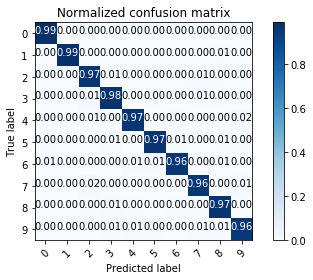

In [13]:
class_n = np.arange(0,10)
plot_confusion_matrix(conf_m, classes=class_n, normalize=True,
                      title='Normalized confusion matrix')

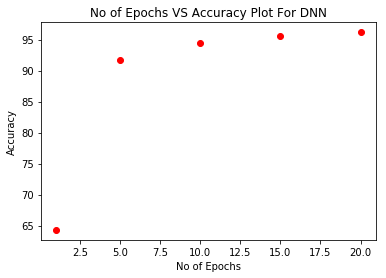

In [14]:
plt.plot([1,5,10,15,20],[64.29,91.76,94.47,95.57,96.19 ],'ro')
plt.ylabel('Accuracy')
plt.xlabel("No of Epochs")
plt.title("No of Epochs VS Accuracy Plot For DNN")
plt.show()

## CONVOLUTIONAL NEURAL NETWORK

In [15]:
conv_shape = [-1, 28, 28, 1]
train_f = train_f.reshape(conv_shape)
val_f = val_f.reshape(conv_shape)

In [16]:
def generate_cnn():
    input_shape=[28, 28, 1]
    dropout=0.2
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    sgd = optimizers.SGD(lr=0.01)
    model.compile(optimizer=sgd, loss=K.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

In [17]:
def train_cnn():
    cnn=generate_cnn()
    num_epochs= 10
    # Creating callbacks
    ten_cb = TensorBoard(log_dir='./logs/dnn', histogram_freq=0, batch_size=32, write_graph=True)
    #early_stop = EarlyStopping(monitor='val_loss', min_delta=10, patience=100, verbose=1, mode='auto', baseline=None)
    
    history = cnn.fit(train_f
                        , train_label_en
                        , validation_data=[val_f, val_label_en]
                        , epochs=num_epochs
                        , batch_size= 256
                        , callbacks = [ten_cb])
    return cnn

In [ ]:
cnn = train_cnn()
evaluate_model(cnn,test_f, test_label_en,test_label)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 8)           1160      
__________

In [ ]:
evaluate(cnn,usps_tf, usps_tlabel_en,usps_tlabel)

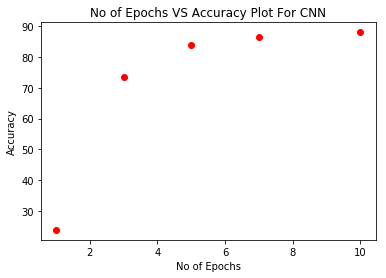

In [19]:
plt.plot([1,3,5,7,10],[23.92,73.55,83.93,86.60,88.01],'ro')
plt.ylabel('Accuracy')
plt.xlabel("No of Epochs")
plt.title("No of Epochs VS Accuracy Plot For CNN")
plt.show()

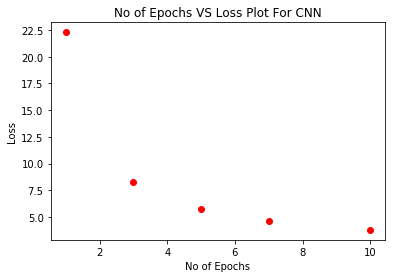

In [20]:
plt.plot([1,3,5,7,10],[22.30,8.24,5.72,4.64,3.78],'ro')
plt.ylabel('Loss')
plt.xlabel("No of Epochs")
plt.title("No of Epochs VS Loss Plot For CNN")
plt.show()

## RANDOM FOREST

In [27]:
train_f, train_label = training_data
val_f, val_label = validation_data
test_f, test_label = test_data

In [29]:
forests=[10,20,50,100,200,500]
for forest in forests:
    classifier_rf = RandomForestClassifier(
                n_estimators=forest, n_jobs=-1, verbose=0)
    classifier_rf.fit(train_f, train_label)
    rf_val = classifier_rf.predict(val_f)
    #rf_val
    print("Val Accuracy:", np.mean(val_label == rf_val) * 100.)
    rf_test = classifier_rf.predict(test_f)
    print("Test Accuracy:", np.mean(test_label == rf_test) * 100.)
    rf_uspstest = classifier_rf.predict(usps_tf)
    print("USPS Test Accuracy:", np.mean(rf_uspstest == usps_tf) * 100.)
    cm = confusion_matrix(test_label, rf_test)
    print(cm)

Val Accuracy: 94.97
Test Accuracy: 94.39999999999999
[[ 967    2    1    1    1    2    2    2    2    0]
 [   0 1119    5    2    0    2    2    0    4    1]
 [   8    2  980    6    5    2    5    9   15    0]
 [   3    2   21  942    0   12    1   12   12    5]
 [   2    2    7    1  932    2    7    2    6   21]
 [  13    2    2   30    7  817    3    4    9    5]
 [   8    3    3    0    7   12  916    0    9    0]
 [   3    5   26   11    2    1    0  964    2   14]
 [   3    3   18   17   12   12    7    5  884   13]
 [   6    5    3   18   32   11    1    9    5  919]]
Val Accuracy: 96.09
Test Accuracy: 95.78
[[ 971    0    0    1    0    2    4    2    0    0]
 [   0 1122    1    3    0    1    4    1    3    0]
 [  10    1  986    8    3    2    2   11    8    1]
 [   1    1   16  960    0   12    0    7   11    2]
 [   1    0    5    0  945    0    4    1    5   21]
 [   7    1    7   20    2  837    4    2    8    4]
 [   6    3    0    1   10    4  930    0    4    0]
 [  

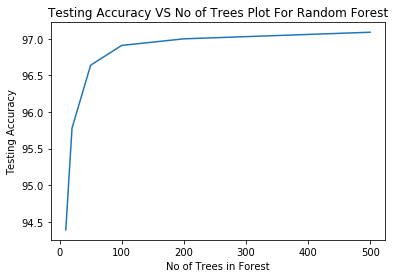

In [23]:
plt.plot([10,20,50,100,200,500],[94.39,95.78,96.64,96.91,97.0,97.09])
plt.ylabel('Testing Accuracy')
plt.xlabel("No of Trees in Forest")
plt.title("Testing Accuracy VS No of Trees Plot For Random Forest")
plt.show()

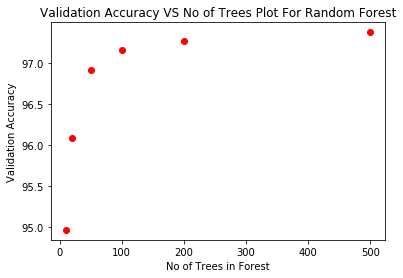

In [25]:
plt.plot([10,20,50,100,200,500],[94.97,96.09,96.91,97.16,97.26,97.37],'ro')
plt.ylabel('Validation Accuracy')
plt.xlabel("No of Trees in Forest")
plt.title("Validation Accuracy VS No of Trees Plot For Random Forest")
plt.show()

## SUPPORT VECTOR MACHINE

Val Accuracy: 98.11999999999999
Test Accuracy: 97.98
USPS Test Accuracy: 41.752087604380215
[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1127    3    1    0    1    1    0    2    0]
 [   5    1 1013    0    1    0    1    7    3    1]
 [   0    0    2  992    0    3    0    6    6    1]
 [   0    0    5    0  962    0    2    0    2   11]
 [   2    0    0   10    2  867    4    1    4    2]
 [   5    2    0    0    2    3  945    0    1    0]
 [   0    6    9    2    2    0    0  998    1   10]
 [   3    0    3    6    5    2    1    3  949    2]
 [   4    4    0    7   11    1    0    7    3  972]]
Normalized confusion matrix
[[9.92857143e-01 0.00000000e+00 1.02040816e-03 0.00000000e+00
  0.00000000e+00 2.04081633e-03 1.02040816e-03 1.02040816e-03
  2.04081633e-03 0.00000000e+00]
 [0.00000000e+00 9.92951542e-01 2.64317181e-03 8.81057269e-04
  0.00000000e+00 8.81057269e-04 8.81057269e-04 0.00000000e+00
  1.76211454e-03 0.00000000e+00]
 [4.84496124e-03 9.68992248e-04 9.8

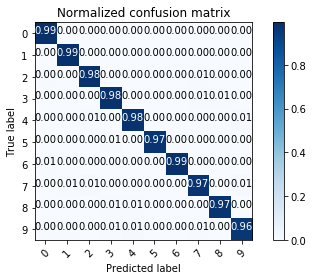

In [11]:
svm = SVC(kernel='rbf', C=2, gamma = 0.01,verbose=0);
svm.fit(train_f, train_label)
svm_val = svm.predict(val_f)
#rf_val
print("Val Accuracy:", np.mean(val_label == svm_val) * 100.)
svm_test = svm.predict(test_f)
print("Test Accuracy:", np.mean(test_label == svm_test) * 100.)
svm_uspstest = svm.predict(usps_tf)
print("USPS Test Accuracy:", np.mean(svm_uspstest == usps_tlabel) * 100.)
cm = confusion_matrix(test_label, svm_test)
print(cm)
class_n = np.arange(0,10)
plot_confusion_matrix(cm, classes=class_n, normalize=True,
                      title='Normalized confusion matrix')

## LOGISTIC REGRESSION

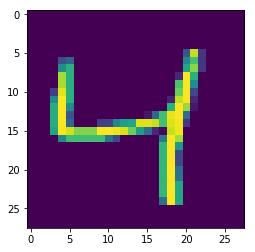

In [10]:
exampleNumber = 2
example = training_data[0][exampleNumber,:] #Then we load that example.
plt.imshow(np.reshape(example,[28,28])) #Next we reshape it to 28x28 and display it.

In [11]:
def softmax(z):
    z = z - np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm
def regression(train_f,train_label):
    lamda = 0.05
    epochs = 1000
    learningRate = 0.01
    batch_size=32
    m= train_f.shape[0]
    losses = []
    w = np.zeros([train_f.shape[1],10])
    b = np.random.random([10])
    #w.shape
    for i in range(0,epochs):
        z = np.dot(train_f,w)+b
        softm = softmax(z)
        loss = np.sum(to_categorical(train_label) * np.log(softm))
        loss = -(loss)/m
        loss += (lamda/2)*np.sum(w*w) 
        grad = (-1 / m) * np.dot(train_f.T,(to_categorical(train_label) - softm))
        grad += lamda*w 
        losses.append(loss)
        w = w - (learningRate * grad)
    print(loss)
    
    plt.plot(losses)   
    train_pred = softmax(np.dot(train_f,w) + b)
    train_pred = np.argmax(train_pred,axis=1)
    train_acc = np.mean(train_label == train_pred) * 100.
    print('Training accuracy:', train_acc)
    test_pred = softmax(np.dot(test_f,w) + b)
    test_pred = np.argmax(test_pred,axis=1)
    test_acc = np.mean(test_label == test_pred) * 100.
    print('Testing accuracy:', test_acc)
    


0.9246478975002514
Training accuracy: 85.542
Training accuracy: 86.75


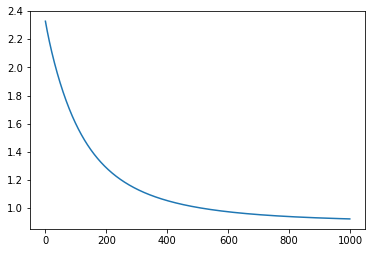

In [12]:
regression(train_f,train_label)